# Using a pretrained convnet

Import the pretrained model:

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Extracting features using the conv_base without data augmentation

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'c:\Users\53556\Documents\Kaggle\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Flatten the features:

In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Defining and training the densely connected classifier:

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 10ms/step - loss: 0.5856 - acc: 0.6895 - val_loss: 0.4286 - val_acc: 0.8490
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.4316 - acc: 0.8085 - val_loss: 0.3573 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3516 - acc: 0.8510 - val_loss: 0.3164 - val_acc: 0.8810
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3137 - acc: 0.8790 - val_loss: 0.2955 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2813 - acc: 0.8880 - val_loss: 0.2809 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2634 - acc: 0.8915 - val_loss: 0.2717 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2413 - acc: 0.9075 - val_loss: 0.2628 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss: 0

Plotting the results:

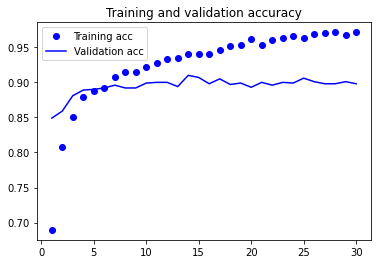

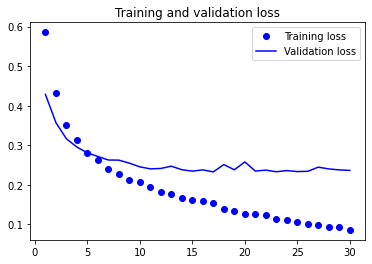

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Feature extraction with data augmentation

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Freezing the conv_base to prevent their weights from being updated during training:

In [12]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))
# Two weight tensors (Weight matrix and bias vector) for each Dense layer

This is the number of trainable weights after freezing the conv base: 4


Training the model:

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 237ms/step - loss: 0.5783 - acc: 0.7050 - val_loss: 0.4482 - val_acc: 0.8030
Epoch 2/30
100/100 [==============================] - 25s 251ms/step - loss: 0.4760 - acc: 0.7810 - val_loss: 0.3663 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 27s 266ms/step - loss: 0.4195 - acc: 0.8235 - val_loss: 0.3327 - val_acc: 0.8640
Epoch 4/30
100/100 [==============================] - 31s 312ms/step - loss: 0.4058 - acc: 0.8150 - val_loss: 0.3099 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 38s 383ms/step - loss: 0.3777 - acc: 0.8355 - val_loss: 0.2971 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 26s 263ms/step - loss: 0.3651 - acc: 0.8430 - val_loss: 0.2896 - val_acc: 0.8810
Epoch 7/30
100/100 [==============================] - 30s 305ms/step - loss: 0.3667 - acc: 0.8325 - val_lo

In [17]:
model.save('cats_and_dogs_small_3.h5')

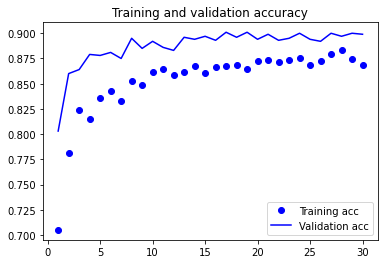

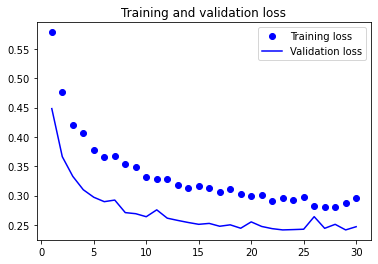

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Fine-tuning

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Freezing all layers up to a specific one

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Fine-tuning the model (using a low leaning rate)

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 29s 288ms/step - loss: 0.2840 - acc: 0.8760 - val_loss: 0.2341 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 28s 283ms/step - loss: 0.2463 - acc: 0.8860 - val_loss: 0.2237 - val_acc: 0.9070
Epoch 3/100
100/100 [==============================] - 31s 306ms/step - loss: 0.2385 - acc: 0.8925 - val_loss: 0.2129 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 32s 319ms/step - loss: 0.2101 - acc: 0.9120 - val_loss: 0.2058 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 31s 314ms/step - loss: 0.2073 - acc: 0.9150 - val_loss: 0.2483 - val_acc: 0.9090
Epoch 6/100
100/100 [==============================] - 30s 305ms/step - loss: 0.1941 - acc: 0.9155 - val_loss: 0.1976 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 33s 332ms/step - loss: 0.1783 - acc: 0.9220 - val_loss: 0.1876 - val_acc: 0.9230
Epoch 8/100
100/100 [===========================

In [24]:
model.save('cats_and_dogs_small_4.h5')

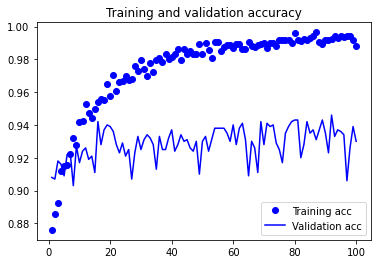

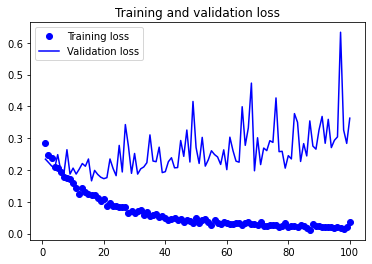

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

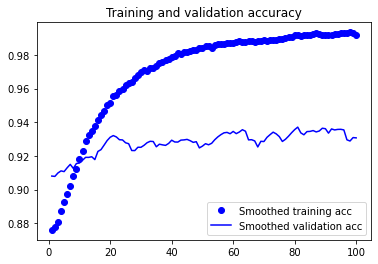

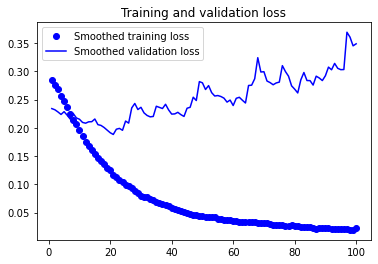

In [26]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 8s 150ms/step - loss: 0.4167 - acc: 0.9340
test acc: 0.9340000152587891
